In [14]:
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [15]:
import pandas as pd
spy = pd.read_csv('newdata/AAPL.csv')
spy.head()

,ticker,AAPL US Equity,AAPL US Equity.1,AAPL US Equity.2,AAPL US Equity.3,AAPL US Equity.4,Close Tomorrow
0,field,PX_LAST,PX_OPEN,MOV_AVG_200D,MOV_AVG_5D,MOV_AVG_50D,NaN
1,date,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,0.999,0.936,0.5644,0.9177,0.8455,0.915
3,2000-01-04,0.915,0.967,0.5675,0.9254,0.8506,0.929
4,2000-01-05,0.929,0.926,0.5706,0.9314,0.8559,0.848


### Data Preparation

In [16]:
dataDate = spy.loc[:, 'ticker'].values
dataLastPrice = spy.loc[:, 'AAPL US Equity'].values

# pop junk out of here
dataDate = dataDate[2:]
dataLP = dataLastPrice[2:].astype(float)

In [17]:
class Transformations():
    def __init__(self):
        self.mu = None
        self.sd = None

    def normalize(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        return (x-self.mu)/self.sd

    def inverseNormalize(self, x):
        return x*self.sd + self.mu

transformer = Transformations()
normLP = transformer.normalize(dataLP)
        

In [18]:
def prepare_data_x(x, window_size):
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, 20)
    data_y = prepare_data_y(normalized_data_close_price, 20)

    # split dataset

    split_index_train_val = int(data_y.shape[0]*0.6)
    split_index_val_test = int(data_y.shape[0]*0.6) + int(data_y.shape[0]*0.2)
    data_x_train = data_x[:split_index_train_val]
    data_x_val = data_x[split_index_train_val:split_index_val_test]
    data_x_test = data_x[split_index_val_test:]

    data_y_train = data_y[:split_index_train_val]
    data_y_val = data_y[split_index_train_val:split_index_val_test]
    data_y_test = data_y[split_index_val_test:]

    return split_index_train_val, data_x_train, data_y_train, data_x_val, data_y_val, data_x_test, data_y_test, data_x_unseen

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_test, data_y_test, data_x_unseen = prepare_data(normLP)

In [19]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)
dataset_test = TimeSeriesDataset(data_x_test, data_y_test)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)
print("Testing data shape", dataset_test.x.shape, dataset_test.y.shape)

Train data shape (3451, 20, 1) (3451,)
Validation data shape (1150, 20, 1) (1150,)
Testing data shape (1152, 20, 1) (1152,)


### The LSTM Model

In [20]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]


input_size = 1 # sine we are only using 1 feature, close price
num_lstm_layers = 2
lstm_size =  32
dropout = 0.2
model = LSTMModel(input_size=input_size, hidden_layer_size=lstm_size, num_layers=num_lstm_layers, output_size=1, dropout=dropout)
model = model.to('cpu')

In [21]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to('cpu')
        y = y.to('cpu')

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

batch_size = 16

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

learning_rate = 0.01
sched_step_size = 40
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=sched_step_size, gamma=0.1)

# begin training
num_epochs = 100

for epoch in range(num_epochs):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] train loss:{:.6f}, val loss:{:.6f}'
              .format(epoch+1, num_epochs, loss_train, loss_val))

Epoch[1/100] train loss:0.159840, val loss:0.046539
Epoch[2/100] train loss:0.016884, val loss:0.137939
Epoch[3/100] train loss:0.007110, val loss:0.057056
Epoch[4/100] train loss:0.006390, val loss:0.055617
Epoch[5/100] train loss:0.003801, val loss:0.024537
Epoch[6/100] train loss:0.003953, val loss:0.059679
Epoch[7/100] train loss:0.003409, val loss:0.078916
Epoch[8/100] train loss:0.003533, val loss:0.073767
Epoch[9/100] train loss:0.003495, val loss:0.071929
Epoch[10/100] train loss:0.003357, val loss:0.027321
Epoch[11/100] train loss:0.003443, val loss:0.068749
Epoch[12/100] train loss:0.003040, val loss:0.089409
Epoch[13/100] train loss:0.003039, val loss:0.058107
Epoch[14/100] train loss:0.002875, val loss:0.038040
Epoch[15/100] train loss:0.003045, val loss:0.071082
Epoch[16/100] train loss:0.002908, val loss:0.054757
Epoch[17/100] train loss:0.002413, val loss:0.061155
Epoch[18/100] train loss:0.002787, val loss:0.023045
Epoch[19/100] train loss:0.002646, val loss:0.034340
Ep

/var/folders/dc/7_b1knps4nxcqls_rqxymh2w0000gn/T/ipykernel_20719/3944797563.py:56: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None, which='major', axis='y', linestyle='--')


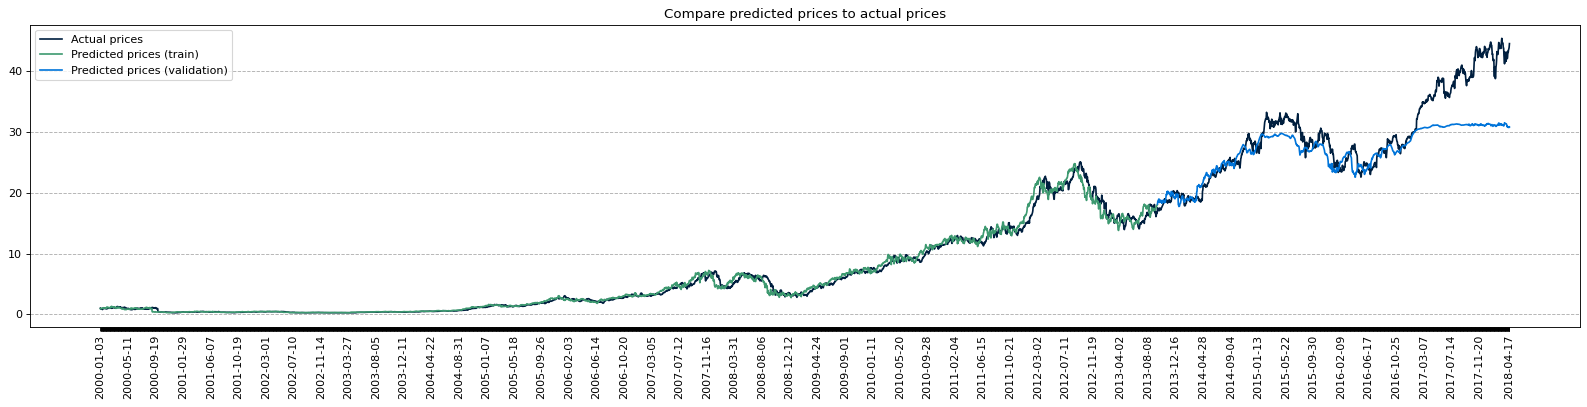

/var/folders/dc/7_b1knps4nxcqls_rqxymh2w0000gn/T/ipykernel_20719/3944797563.py:76: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None, which='major', axis='y', linestyle='--')


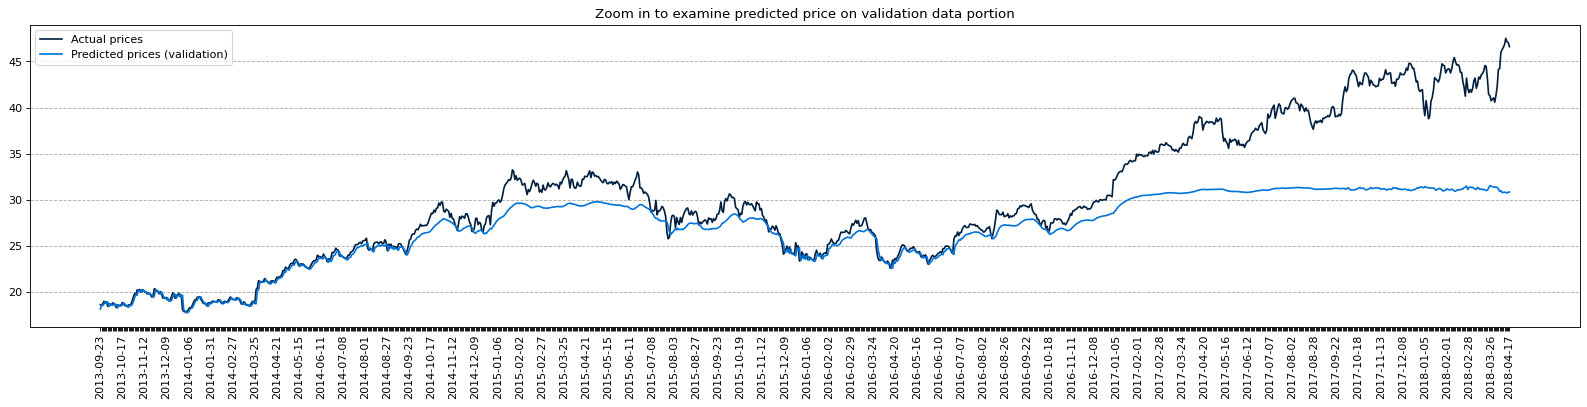

In [22]:
num_data_points = len(data_x_train) + len(data_x_val)

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
xticks_interval =  90
color_actual = "#001f3f"
color_train = "#3D9970"
color_val = "#0074D9"
color_pred_train= "#3D9970"
color_pred_val = "#0074D9"
color_pred_test = "#FF4136"


model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to('cpu')
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to('cpu')
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))


to_plot_data_y_train_pred = np.zeros(num_data_points)
to_plot_data_y_val_pred = np.zeros(num_data_points)
to_plot_data_y_train_pred[0:split_index] = transformer.inverseNormalize(predicted_train)
to_plot_data_y_val_pred[split_index:] = transformer.inverseNormalize(predicted_val)

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(dataDate[:num_data_points], dataLP[:num_data_points], label="Actual prices", color=color_actual)
plt.plot(dataDate[:num_data_points], to_plot_data_y_train_pred, label="Predicted prices (train)", color=color_pred_train)
plt.plot(dataDate[:num_data_points], to_plot_data_y_val_pred, label="Predicted prices (validation)", color=color_pred_val)
plt.title("Compare predicted prices to actual prices")
xticks = [dataDate[i] if ((i%xticks_interval==0 and (num_data_points-i) > xticks_interval) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

# prepare data for plotting, zoom in validation

to_plot_data_y_val_subset = transformer.inverseNormalize(data_y_val)
to_plot_predicted_val = transformer.inverseNormalize(predicted_val)
to_plot_data_date = dataDate[split_index:num_data_points]

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=color_actual)
plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=color_pred_val)
plt.title("Zoom in to examine predicted price on validation data portion")
xticks = [to_plot_data_date[i] if ((i%int(xticks_interval/5)==0 and (len(to_plot_data_date)-i) > xticks_interval/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
xs = np.arange(0,len(xticks))
plt.xticks(xs, xticks, rotation='vertical')
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()


### When I am all done... the TEST SET